In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import random
import os 
%matplotlib inline 

imgs = os.listdir('data')
imgs = [i for i in imgs if (('.jpg' in i) and ('train' not in  i))]
posimg = ['./data/'+i for i in imgs if '_1' in i]
negimg = ['./data/'+i for i in imgs if '_0' in i]
win_size = (48,48)
block_size = (16,16)
block_stride = (8,8)
cell_size = (8,8)
num_bins = 9
img_avg = 120
hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size,num_bins)

random.seed(42)

def gethog(imgs):
    X = []
    for filename in random.sample(imgs,len(imgs)):
        img = cv2.imread(filename)
        if img is None:
            print('Could not find image %s'%filename)
            continue
        X.append(hog.compute(img,(120,120)))
    return X
    #opencv需要特征矩阵包含32位浮点数，而且目标标签是32位的整数。

X_pos = gethog(posimg)
X_pos = np.array(X_pos,dtype = np.float32)
y_pos = np.ones(X_pos.shape[0],dtype = np.int32)
print(X_pos.shape,y_pos.shape)

X_neg = gethog(negimg)
X_neg = np.array(X_neg,dtype = np.float32)
y_neg = -np.ones(X_neg.shape[0],dtype = np.int32)

#合并 数据集
X = np.concatenate((X_pos,X_neg))
y = np.concatenate((y_pos,y_neg))
from sklearn import model_selection as ms
X_train,X_test,y_train,y_test = ms.train_test_split(X,y,test_size = 0.2,random_state = 42)
#实现支持向量机
def train_svm(X_train,y_train):
    svm = cv2.ml.SVM_create()
    svm.setKernel(cv2.ml.SVM_LINEAR)
    svm.train(X_train,cv2.ml.ROW_SAMPLE,y_train)
    return svm

def score_svm(svm,X,y):
    from sklearn import metrics
    _,y_pred = svm.predict(X)
    return metrics.accuracy_score(y,y_pred)

svm = train_svm(X_train,y_train)
sc = score_svm(svm,X_train,y_train)
print(sc)
sc = score_svm(svm,X_test,y_test)
print(sc)
print(hog.getDescriptorSize())

(0,) (0,)


ValueError: all the input arrays must have same number of dimensions

In [3]:
#模型自举，其实相当于当时那个超新星的说的用于反复训练的方法
score_train = []
score_test = []
while True:
    svm = train_svm(X_train,y_train)
    score_train.append(score_svm(svm,X_train,y_train))
    score_test.append(score_svm(svm,X_test,y_test))
    #找到假正图片，当然，没有则结束
    _,y_pred = svm.predict(X_test)
    
    false_pos = np.logical_and((y_test.ravel()==-1),(y_pred.ravel()==1))
    false_neg = np.logical_and((y_test.ravel()== 1),(y_pred.ravel()==-1))
    
    if not (np.any(false_pos) or np.any(false_neg)):#非空返回True，空返回False，None返回None
        print('no more false positives:done ')
        break
    X_train = np.concatenate((X_train,X_test[false_pos,:]),axis = 0)
    X_train = np.concatenate((X_train,X_test[false_neg,:]),axis = 0)
    y_train = np.concatenate((y_train,y_test[false_pos]),axis = 0)
    y_train = np.concatenate((y_train,y_test[false_neg]),axis = 0)

print(score_train)
print(score_test)
print(hog.getDescriptorSize())

NameError: name 'train_svm' is not defined

In [1]:
#在更大的图像中检测行人，所以，我们只要在图像中，
stride = 16
hroi=120;wroi = 120;
found = [];fw = []
img_test = cv2.imread('./rawdata/train_0.jpg')
img_draw = img_test.copy()#在下一个cell中使用它并使用cv2.rectangle进行人体标记，预计能看到其效果有多差
#img_test = np.array(img_test,dtype = np.float32)
for ystart in np.arange(0,img_test.shape[0],stride):
    for xstart in np.arange(0,img_test.shape[1],stride):
        if ystart+hroi>img_test.shape[0]:
            continue
        if xstart+wroi>img_test.shape[1]:
            continue
        roi = img_test[ystart:ystart+hroi,
                      xstart:xstart+wroi,:]
        feat = np.array([hog.compute(roi,(120,120))],dtype = np.float32)#书中没有将其转化位foat32，但转了后还是 错啊
        w,ypred = svm.predict(feat)
        if np.allclose(ypred,1):
            found.append((ystart,xstart,hroi,wroi))
            fw.append(w)

#plt.imshow(img_test)
#plt.show()
print(img_test.shape)
print(len(found))

NameError: name 'cv2' is not defined

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
#found = found_raw[0][:10]
for j in range(len(found)):
    #if found[j].size==1:
    #    continue
    i=found[j]
    img_draw = img_test.copy()
    cv2.rectangle(img_draw,(i[0],i[1]),(i[0]+i[2],i[1]+i[3]),(0,255,0),2)#参考人脸识别的，此处是x,y,h,w
    img_draw = cv2.cvtColor(img_draw,cv2.COLOR_BGR2RGB)
    plt.imshow(img_draw)
    plt.pause(2)
    plt.show()

In [6]:
#检测函数
img_test = cv2.imread('./rawdata/train_0.jpg')
rho,rho_1,rho_2 = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()
#hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size,num_bins)
hog.setSVMDetector(np.append(sv.ravel(),-rho))
#sv_use = sv
#sv_use = sv[1,:].ravel()
#sv_use = np.append(sv_use,rho)
#sv_use = sv_use.reshape(sv_use.shape[0],1)
#hog = cv2.HOGDescriptor()
#hog.setSVMDetector(sv_use)#里头的append操作应该是没问题的
#hog.setSVMDetector(sv)
found,fw = hog.detectMultiScale(img_test,scale = 1.4)
print(len(found))

NameError: name 'svm' is not defined

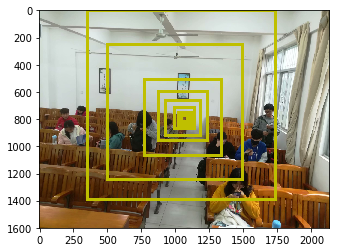

In [25]:
from matplotlib import patches
fig = plt.figure()
ax = fig.add_subplot(111)
img_draw = img_test.copy()
img_draw = cv2.cvtColor(img_draw,cv2.COLOR_BGR2RGB)
ax.imshow(img_draw)
for f in found:
    ax.add_patch(patches.Rectangle((f[0],f[1]),f[2],f[3],color = 'y',linewidth = 3,fill = False))

In [92]:
found_use = [found[i] for i in range(len(found)) if fw[i]>1]

In [93]:
len(found_use)

1332

In [183]:
help(hog.detectMultiScale)

Help on built-in function detectMultiScale:

detectMultiScale(...) method of cv2.HOGDescriptor instance
    detectMultiScale(img[, hitThreshold[, winStride[, padding[, scale[, finalThreshold[, useMeanshiftGrouping]]]]]]) -> foundLocations, foundWeights
    .   @brief Detects objects of different sizes in the input image. The detected objects are returned as a list
    .   of rectangles.
    .   @param img Matrix of the type CV_8U or CV_8UC3 containing an image where objects are detected.
    .   @param foundLocations Vector of rectangles where each rectangle contains the detected object.
    .   @param foundWeights Vector that will contain confidence values for each detected object.
    .   @param hitThreshold Threshold for the distance between features and SVM classifying plane.
    .   Usually it is 0 and should be specified in the detector coefficients (as the last free coefficient).
    .   But if the free coefficient is omitted (which is allowed), you can specify it manually here.

In [7]:
from matplotlib import patches

for f in pick:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    img_draw = img_test.copy()
    img_draw = cv2.cvtColor(img_draw,cv2.COLOR_BGR2RGB)
    ax.imshow(img_draw)
    ax.add_patch(patches.Rectangle((f[0],f[1]),f[2],f[3],color = 'y',linewidth = 3,fill = False))

NameError: name 'pick' is not defined

In [32]:
from imutils.object_detection import non_max_suppression
rects = np.array([[found[i,0], found[i,1], found[i,0] + found[i,2], found[i,1] + found[i,3]] for i in range(found.shape[0])])
sc = fw

pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.05)
print(len(pick))

AttributeError: 'list' object has no attribute 'shape'

In [139]:
from PIL import Image
for i in range(47,53):
    imgname = f'{i}_1.jpg'
    t = Image.open(f'./rawdata/{imgname}')
    t = t.resize((120,120))
    t.save(f't_{imgname}')
    t = cv2.imread(f't_{imgname}')
    neg = hog.compute(t,(120,120))
    neg = neg.reshape(1,neg.shape[0],1)
    print(neg.shape)
    _,y_a = svm.predict(neg)
    print(y_a)
    print(imgname)

(1, 900, 1)
[[-1.]]
47_1.jpg
(1, 900, 1)
[[1.]]
48_1.jpg
(1, 900, 1)
[[1.]]
49_1.jpg
(1, 900, 1)
[[-1.]]
50_1.jpg
(1, 900, 1)
[[-1.]]
51_1.jpg
(1, 900, 1)
[[1.]]
52_1.jpg


In [21]:
from PIL import Image
img_cut = img_test.copy()
img_cut = cv2.cvtColor(img_cut,cv2.COLOR_BGR2RGB)
count = 360
if not os.path.exists('temp'):
    os.mkdir('temp')
for i in found:
    count += 1
    img_save = img_cut[i[1]:i[1]+i[3],i[0]:i[0]+i[2],:]
    img_save = Image.fromarray(img_save)
    img_save.save(f'./temp/{count}_0.jpg')

In [40]:
from imutils.object_detection import non_max_suppression
rects = np.array([[i[0],i[1], i[0] + i[2], i[1] + i[3]] for i in found])
print(rects.shape)
fw = np.array(fw)
sc = fw

pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.05)
print(len(pick))

(507, 4)
79


In [99]:
import numpy as np 
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression
import imutils
from skimage.feature import hog
from sklearn.externals import joblib
import cv2
from config import *
from skimage import color
import matplotlib.pyplot as plt 
import os 
import glob

def sliding_window(image, window_size, step_size):
	'''
	This function returns a patch of the input 'image' of size 
	equal to 'window_size'. The first image returned top-left 
	co-ordinate (0, 0) and are increment in both x and y directions
	by the 'step_size' supplied.

	So, the input parameters are-
	image - Input image
	window_size - Size of Sliding Window 
	step_size - incremented Size of Window

	The function returns a tuple -
	(x, y, im_window)
	'''
	for y in range(0, image.shape[0], step_size[1]):
		for x in range(0, image.shape[1], step_size[0]):
			yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

def detector(filename):
	im = cv2.imread(filename)
	if filename.split('.')[-1]=='png':
		os.rename(filename,'test_image/area_'+filename.split('_')[-1])
		im = cv2.imread('test_image/area_'+filename.split('_')[-1])
	im = imutils.resize(im, width = min(400, im.shape[1]))
	min_wdw_sz = (64, 128)
	step_size = (10, 10)
	downscale = 1.25

	clf = joblib.load(os.path.join(model_path, 'svm.model'))

	#List to store the detections
	detections = []
	#The current scale of the image 
	scale = 0

	for im_scaled in pyramid_gaussian(im, downscale = downscale):
		#The list contains detections at the current scale
		if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
			break
		for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
			if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
				continue
			im_window = color.rgb2gray(im_window)
			fd = hog(im_window, orientations, pixels_per_cell, cells_per_block,'L1', visualize)

			fd = fd.reshape(1, -1)
			pred = clf.predict(fd)

			if pred == 1:
				
				if clf.decision_function(fd) > 0.5:
					detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), clf.decision_function(fd), 
					int(min_wdw_sz[0] * (downscale**scale)),
					int(min_wdw_sz[1] * (downscale**scale))))
			
		scale += 1

	clone = im.copy()

	for (x_tl, y_tl, _, w, h) in detections:
		cv2.rectangle(im, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 255, 0), thickness = 2)

	rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
	sc = [score[0] for (x, y, score, w, h) in detections]
	print("sc: ", sc)
	sc = np.array(sc)
	pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)
	print("shape, ", pick.shape)

	for(xA, yA, xB, yB) in pick:
		cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 2)
	
	plt.axis("off")
	plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
	plt.title("Raw Detection before NMS")
	plt.show()

	plt.axis("off")
	plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
	plt.title("Final Detections after applying NMS")
	plt.show()

def test_folder(foldername):

	filenames = glob.iglob(os.path.join(foldername, '*'))
	for filename in filenames:
		detector(filename)

if __name__ == '__main__':
	foldername = 'test_image'
	test_folder(foldername)


array([[ 347,    0, 1388, 1388],
       [ 713,  521,  562,  562],
       [ 455,  241,  992,  992],
       [ 781,  601,  361,  361],
       [1656,  150,  361,  361],
       [ 892,  718,  149,  149],
       [1695,  281,  184,  184],
       [ 836,  661,  258,  258],
       [1700,  226,  258,  258],
       [ 921,  758,   94,   94],
       [1951,   26,   94,   94],
       [1924,   73,   94,   94],
       [1822,  143,   94,   94],
       [1962,  182,   94,   94],
       [1740,  340,   94,   94],
       [1584,  290,   94,   94],
       [1895,  487,   94,   94],
       [  36, 1249,   94,   94],
       [1961,    7,  132,  132],
       [1796,  132,  132,  132],
       [1731,  312,  132,  132],
       [1828,  606,  132,  132],
       [ 956,  767,   48,   48],
       [1124,    4,   48,   48],
       [1164,   12,   48,   48],
       [2077,   31,   48,   48],
       [2047,   98,   48,   48],
       [1843,  238,   48,   48],
       [2076,  158,   48,   48],
       [1989,  222,   48,   48],
       [20

In [20]:
print(found)

[[ 231    0 1388 1388]
 [ 496  261  992  992]
 [ 787  511  561  561]
 [ 884  585  361  361]
 [ 997  714  149  149]
 [ 928  663  258  258]
 [1023  747   94   94]
 [1033  754   67   67]
 [1041  767   48   48]
 [1236 1552   48   48]]
